
# REBEL

In [6]:
from transformers import pipeline
import textwrap
import networkx as nx
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import math
import torch
import matplotlib.pyplot as plt

In [7]:
tokenizer = AutoTokenizer.from_pretrained("Babelscape/rebel-large")
model = AutoModelForSeq2SeqLM.from_pretrained("Babelscape/rebel-large")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [8]:
def extract_relations_from_model_output(text):
    relations = []
    relation, subject, relation, object_ = '', '', '', ''
    text = text.strip()
    current = 'x'
    text_replaced = text.replace("<s>", "").replace("<pad>", "").replace("</s>", "")
    for token in text_replaced.split():
        if token == "<triplet>":
            current = 't'
            if relation != '':
                relations.append({
                    'head': subject.strip(),
                    'type': relation.strip(),
                    'tail': object_.strip()
                })
                relation = ''
            subject = ''
        elif token == "<subj>":
            current = 's'
            if relation != '':
                relations.append({
                    'head': subject.strip(),
                    'type': relation.strip(),
                    'tail': object_.strip()
                })
            object_ = ''
        elif token == "<obj>":
            current = 'o'
            relation = ''
        else:
            if current == 't':
                subject += ' ' + token
            elif current == 's':
                object_ += ' ' + token
            elif current == 'o':
                relation += ' ' + token
    if subject != '' and relation != '' and object_ != '':
        relations.append({
            'head': subject.strip(),
            'type': relation.strip(),
            'tail': object_.strip()
        })
    return relations

In [9]:
class KB():
    def __init__(self):
        self.relations = []

    def are_relations_equal(self, r1, r2):
        return all(r1[attr] == r2[attr] for attr in ["head", "type", "tail"])

    def exists_relation(self, r1):
        return any(self.are_relations_equal(r1, r2) for r2 in self.relations)

    def merge_relations(self, r1):
        r2 = [r for r in self.relations
              if self.are_relations_equal(r1, r)][0]
        spans_to_add = [span for span in r1["meta"]["spans"]
                        if span not in r2["meta"]["spans"]]
        r2["meta"]["spans"] += spans_to_add

    def add_relation(self, r):
        if not self.exists_relation(r):
            self.relations.append(r)
        else:
            self.merge_relations(r)

    def print(self):
        print("Relations:")
        for r in self.relations:
            print(f"  {r}")

In [10]:
def from_text_to_kb(text, span_length=128, verbose=False):
    # tokenize whole text
    inputs = tokenizer([text], return_tensors="pt")

    # compute span boundaries
    num_tokens = len(inputs["input_ids"][0])
    if verbose:
        print(f"Input has {num_tokens} tokens")
    num_spans = math.ceil(num_tokens / span_length)
    if verbose:
        print(f"Input has {num_spans} spans")
    overlap = math.ceil((num_spans * span_length - num_tokens) / 
                        max(num_spans - 1, 1))
    spans_boundaries = []
    start = 0
    for i in range(num_spans):
        spans_boundaries.append([start + span_length * i,
                                 start + span_length * (i + 1)])
        start -= overlap
    if verbose:
        print(f"Span boundaries are {spans_boundaries}")

    # transform input with spans
    tensor_ids = [inputs["input_ids"][0][boundary[0]:boundary[1]]
                  for boundary in spans_boundaries]
    tensor_masks = [inputs["attention_mask"][0][boundary[0]:boundary[1]]
                    for boundary in spans_boundaries]
    inputs = {
        "input_ids": torch.stack(tensor_ids),
        "attention_mask": torch.stack(tensor_masks)
    }

    # generate relations
    num_return_sequences = 3
    gen_kwargs = {
        "max_length": 256,
        "length_penalty": 0,
        "num_beams": 3,
        "num_return_sequences": num_return_sequences
    }
    generated_tokens = model.generate(
        **inputs,
        **gen_kwargs,
    )

    # decode relations
    decoded_preds = tokenizer.batch_decode(generated_tokens,
                                           skip_special_tokens=False)

    # create kb
    kb = KB()
    i = 0
    for sentence_pred in decoded_preds:
        current_span_index = i // num_return_sequences
        relations = extract_relations_from_model_output(sentence_pred)
        for relation in relations:
            relation["meta"] = {
                "spans": [spans_boundaries[current_span_index]]
            }
            kb.add_relation(relation)
        i += 1

    return kb

In [13]:
with (open("text.txt", "r", encoding="UTF-8") as f):
    f = f.read()
    kb = from_text_to_kb(f, verbose=True)
    kb.print()

Input has 903 tokens
Input has 8 spans
Span boundaries are [[0, 128], [110, 238], [220, 348], [330, 458], [440, 568], [550, 678], [660, 788], [770, 898]]
Relations:
  {'head': 'Mufasa', 'type': 'spouse', 'tail': 'Sarabi', 'meta': {'spans': [[0, 128]]}}
  {'head': 'Mufasa', 'type': 'child', 'tail': 'Simba', 'meta': {'spans': [[0, 128]]}}
  {'head': 'Mufasa', 'type': 'sibling', 'tail': 'Scar', 'meta': {'spans': [[0, 128]]}}
  {'head': 'Sarabi', 'type': 'spouse', 'tail': 'Mufasa', 'meta': {'spans': [[0, 128]]}}
  {'head': 'Sarabi', 'type': 'child', 'tail': 'Simba', 'meta': {'spans': [[0, 128]]}}
  {'head': 'Simba', 'type': 'father', 'tail': 'Mufasa', 'meta': {'spans': [[0, 128]]}}
  {'head': 'Simba', 'type': 'mother', 'tail': 'Sarabi', 'meta': {'spans': [[0, 128]]}}
  {'head': 'Scar', 'type': 'sibling', 'tail': 'Mufasa', 'meta': {'spans': [[0, 128]]}}
  {'head': 'Simba', 'type': 'sibling', 'tail': 'Scar', 'meta': {'spans': [[0, 128]]}}
  {'head': 'Scar', 'type': 'sibling', 'tail': 'Simba'

In [14]:

G = nx.DiGraph()

relation = {}
k = 0
for i, elem in enumerate(kb.relations):
    if elem['tail'] not in relation:
        relation[elem['tail']] = k
        G.add_node(k, name = relation[elem['tail']])
        k += 1
        
    if elem['head'] not in relation:
        relation[elem['head']] = k
        G.add_node(k, name=elem['head'])
        k += 1

    G.add_edge(relation[elem['head']], relation[elem['tail']], name = elem['type'])

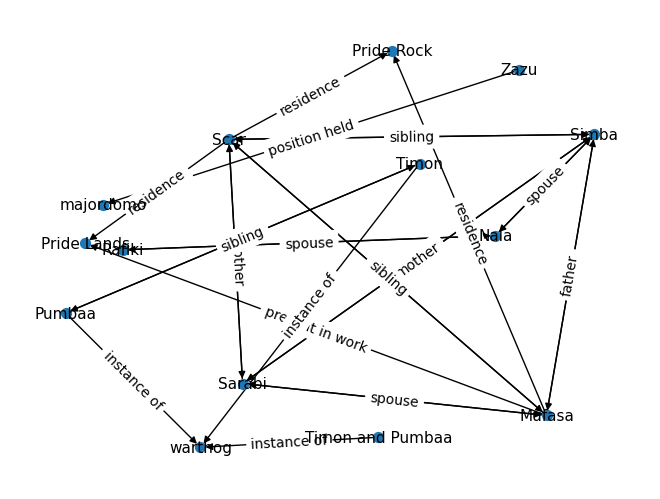

In [19]:
inv_map = {v: k for k, v in relation.items()}
pos = nx.random_layout(G)
edge_labels = dict([((n1, n2), d['name'])
                    for n1, n2, d in G.edges(data=True)])

options = {
    'labels':inv_map,
    'with_labels':True,
    'node_size': 50,
    'pos': pos,
    'font_size':11
}

nx.draw(G, **options)
nx.draw_networkx_edge_labels(G, pos,edge_labels=edge_labels)
plt.show()